In [1]:
from google.colab import drive
drive.mount('/content/my')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/my


This notebook shows an outline of the BTC_DQN project (detailed codes are in the 'Version 2' folder). In this project, I try to develop an reinforcement learning agent in Bitcoin trading market in order to find some noval trading strategies.

PART 1: Data pre-processing and predictions

A historical BTC price data is collected from 2014-12-1 to 2019-1-9 on both minutely basis and daily basis. Here is a first look of the data. The missing data are backward-filled. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
path = 'my/My Drive/BTC_DQN/data/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv'
df = pd.read_csv(path)
df.head()
df.fillna('bfill')

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300,300,300,300,0.01,3,300
1,1417412040,bfill,bfill,bfill,bfill,bfill,bfill,bfill
2,1417412100,bfill,bfill,bfill,bfill,bfill,bfill,bfill
3,1417412160,bfill,bfill,bfill,bfill,bfill,bfill,bfill
4,1417412220,bfill,bfill,bfill,bfill,bfill,bfill,bfill
...,...,...,...,...,...,...,...,...
2099755,1546898520,4006.01,4006.57,4006,4006.01,3.38295,13553.4,4006.39
2099756,1546898580,4006.01,4006.57,4006,4006.01,0.902164,3614.08,4006.02
2099757,1546898640,4006.01,4006.01,4006,4006.01,1.19212,4775.65,4006
2099758,1546898700,4006.01,4006.01,4005.5,4005.5,2.6997,10814.2,4005.72


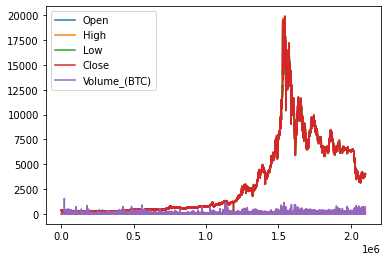

In [3]:
df[['Open','High','Low','Close','Volume_(BTC)']].plot()

A window of the hsitorical values of 'Open, Close, High, Low, Volume_Currency, Weighted_Price' is a part of the state that the reinforcement agent can observe. Besides, this state also includes the value of 'cash in pocket, BTC holds, total asset' and predictions of the price in the next two steps. 

The prediction can be done in a traditional time series model, e.g., ARIMA model. (A daily based data is now used to save time and storage.) I make predictions on the 'Close' value as an example.

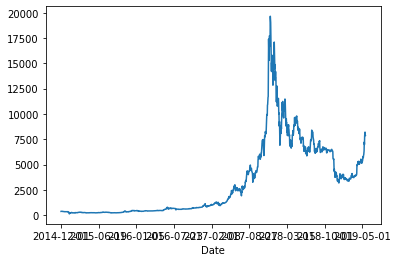

In [4]:
df = pd.read_csv('my/My Drive/BTC_DQN/data/coinbase_daily.csv')
date = df['Date']
Open = pd.Series(df['Open'].iloc[::-1].values, index=date.iloc[::-1])
Close = pd.Series(df['Close'].iloc[::-1].values, index=date.iloc[::-1])
High = pd.Series(df['High'].iloc[::-1].values, index=date.iloc[::-1])
Low = pd.Series(df['Low'].iloc[::-1].values, index=date.iloc[::-1])
Volume = pd.Series(df['Volume BTC'].iloc[::-1].values, index=date.iloc[::-1])
Close.plot()

An ADF test is conducted to check the stationarity of the data (actually it's not necessary since the non-stationarity can be easily seen from naked eye).

In [5]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def stationary_test(data):#ADF
    test_stats = adfuller(data)
    summary1 = pd.Series(test_stats[0:4], index=['ADF statistic', 'P value', 'number of lags', 'number of observations'])
    critics = [test_stats[4][key] for key in test_stats[4]]
    summary2 = pd.Series(critics, index=['1% critic value', '5% critic value', '10% critic value'])
    summary = pd.concat([summary1, summary2], axis=0)
    print(summary)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
stationary_test(Close)

ADF statistic               -1.740496
P value                      0.410378
number of lags              23.000000
number of observations    1593.000000
1% critic value             -3.434462
5% critic value             -2.863356
10% critic value            -2.567737
dtype: float64


Here, the high P-value indicates a failure to reject the H_0, and thus this series is not stationary. Then, I built an ARIMA model.

In [7]:
class ARIMA_model():
    def __init__(self, train, test):#Series
        self.train = train
        self.test = test

    def plot_acf_pacf(self, data):
        fig, axes = plt.subplots(1,2)
        plot_acf(data, ax=axes[0])
        plot_pacf(data, ax=axes[1])

    def forecast(self, p,d,q):
        model_fit = ARIMA(self.train.values, (p,d,q)).fit(disp=-1)
        print(model_fit.summary())
        pred, se, conf = model_fit.forecast(len(test.index), alpha = 0.05)
        plt.figure()
        plt.plot(train.index, train)
        plt.plot(test.index, pred)
        plt.fill_between(test.index, conf[:,0], conf[:,1], alpha = 0.15)
        plt.plot(test.index, test)
        plt.legend(['train','prediction','test'])
        plt.show()
        return model_fit

As an example, only a small portion of the data is used

In [8]:
train = Close.iloc[int(0.6*len(Close)):int(0.7*len(Close))]
test = Close.iloc[int(0.7*len(Close)):int(0.75*len(Close))]
model = ARIMA_model(train, test)

Determining degree of freedom by looking at the ACF and PACF.

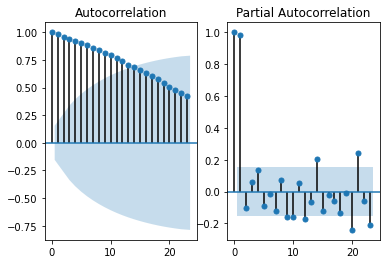

In [9]:
model.plot_acf_pacf(train)

This ACF shows a obvious nonstationarity. So at least 1 order difference should be done.

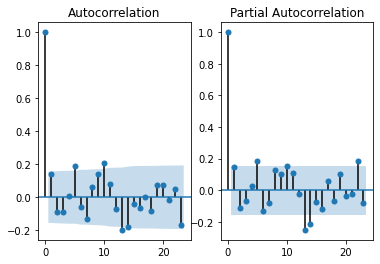

In [10]:
model.plot_acf_pacf(np.diff(train))

Now, these looks fine. From the acf, I guess q=1, while p=1 from the pacf. In this case, the ARIMA model would be of order (1,1,1)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  160
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1240.558
Method:                       css-mle   S.D. of innovations            563.646
Date:                Mon, 27 Jul 2020   AIC                           2489.117
Time:                        15:17:40   BIC                           2501.417
Sample:                             1   HQIC                          2494.112
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         77.5293     49.471      1.567      0.119     -19.431     174.490
ar.L1.D.y     -0.3977      0.635     -0.626      0.532      -1.643       0.847
ma.L1.D.y      0.5520      0.588      0.939      0.3

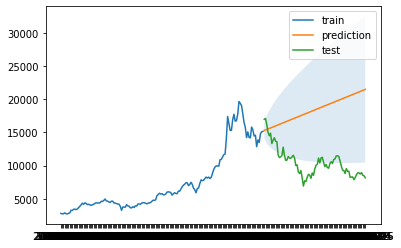

In [11]:
model_fit = model.forecast(1,1,1)

Well, this prediction looks okay at least in the most near future and the AIC is also low.

But, I'm still interested to see how better an LSTM can do. In this case, I trained an LSTM. Data is re-scaled by their std.

In [12]:
from sklearn.preprocessing import StandardScaler
def pre_process(data):
    data = data.values
    STDscaler = StandardScaler()
    STDscaler.fit(data.reshape(-1, 1))#uniform scale
    #normalize by regions
    data_part1 = data[:900]
    data_part2 = data[900:1050]
    data_part3 = data[1050:1200]
    data_part4 = data[1200:]
    data_by_parts = [data_part1, data_part2, data_part3, data_part4]
    data_scaled = []
    for part in data_by_parts:
        temp = STDscaler.transform(np.reshape(part, (-1, 1)))
        data_scaled.append(temp)
    data_scaled = np.concatenate(data_scaled, axis=0)
    return STDscaler, data_scaled

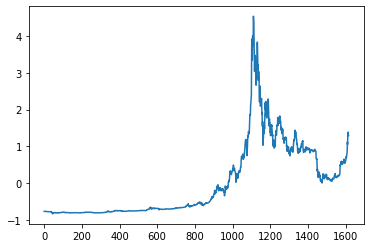

In [13]:
STDscaler, data_scaled = pre_process(Close)
plt.plot(data_scaled)

80% percent of the data used for training and the rest for testing.

In [14]:
def train_test_split(data, lookback_window):
    data_LSTM = np.ndarray(shape=(data.shape[0]-lookback_window, lookback_window+1))
    for i in range(lookback_window+1):
        data_LSTM[:, i] = data[i:data.shape[0]-lookback_window+i, 0]
    train = data_LSTM[:int(0.8*data.shape[0]),:]
    test = data_LSTM[int(0.8*data.shape[0]):,:]
    train_x = train[:,:lookback_window]
    train_y = train[:,-1]
    test_x = test[:,:lookback_window]
    test_y = test[:,-1]

    train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
    train_y = np.reshape(train_y, (len(train_y),1))
    test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))
    test_y = np.reshape(test_y, (len(test_y), 1))
    return train_x, train_y, test_x, test_y

In [15]:
train_x, train_y, test_x, test_y = train_test_split(data_scaled, 10)

An LSTM model is built with 3 internal state neurals.

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
def LSTM_model(train_x, train_y, test_x, test_y):#ndarray(-1,1,window), ndarray(-1,1)
    model = Sequential()
    model.add(LSTM(3, batch_input_shape=(1, 1, train_x.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(optimizer='Adam', loss='mean_squared_error')
    epochs = 30
    test_error = []
    for i in range(epochs):
        print('EPOCH:', i)
        model.fit(train_x, train_y, batch_size=1, verbose=1)
        prediction = model.predict(test_x, batch_size=1)
        test_MSE = (np.dot((prediction[:, 0] - test_y[:, 0]), (prediction[:, 0] - test_y[:, 0]))) ** (0.5) / \
                   prediction.shape[0]
        test_error.append(test_MSE)
        model.reset_states()
    prediction = model.predict(test_x, batch_size=1)
    #in-sample error
    train_prediction = model.predict(train_x, batch_size=1)

    test_MSE = (np.dot((prediction[:,0]-test_y[:,0]), (prediction[:,0]-test_y[:,0])))**(0.5)/prediction.shape[0]
    train_MSE = (np.dot((train_prediction[:, 0] - train_y[:, 0]), (train_prediction[:, 0] - train_y[:, 0])))**(0.5)/train_prediction.shape[0]


    plt.figure()
    plt.plot(prediction)
    plt.plot(test_y)
    plt.legend(['predict', 'test_y'])
    plt.title('LSTM_predict')
    plt.figure()
    plt.plot((train_prediction))
    plt.plot(train_y)
    plt.legend(['train_predict','train_y'])
    plt.figure()
    plt.plot(test_error)
    plt.title('performance metric')
    plt.show()

    return prediction, model

Using TensorFlow backend.


EPOCH: 0
Epoch 1/1
1293/1293 [==============================] - 2s 2ms/step - loss: 0.6065
EPOCH: 1
Epoch 1/1
1293/1293 [==============================] - 2s 1ms/step - loss: 0.2514
EPOCH: 2
Epoch 1/1
1293/1293 [==============================] - 2s 1ms/step - loss: 0.1208
EPOCH: 3
Epoch 1/1
1293/1293 [==============================] - 2s 1ms/step - loss: 0.0794
EPOCH: 4
Epoch 1/1
1293/1293 [==============================] - 2s 1ms/step - loss: 0.0558
EPOCH: 5
Epoch 1/1
1293/1293 [==============================] - 2s 1ms/step - loss: 0.0430
EPOCH: 6
Epoch 1/1
1293/1293 [==============================] - 2s 1ms/step - loss: 0.0326
EPOCH: 7
Epoch 1/1
1293/1293 [==============================] - 2s 1ms/step - loss: 0.0281
EPOCH: 8
Epoch 1/1
1293/1293 [==============================] - 2s 1ms/step - loss: 0.0240
EPOCH: 9
Epoch 1/1
1293/1293 [==============================] - 2s 1ms/step - loss: 0.0218
EPOCH: 10
Epoch 1/1
1293/1293 [==============================] - 2s 1ms/step - loss: 0.019

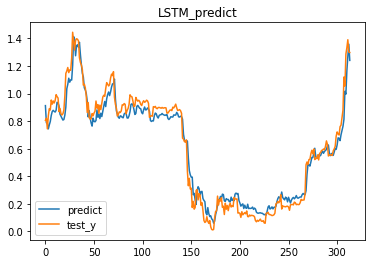

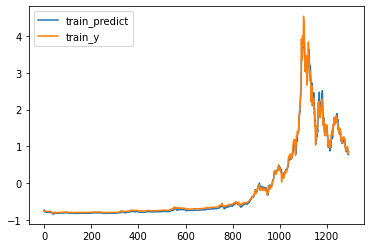

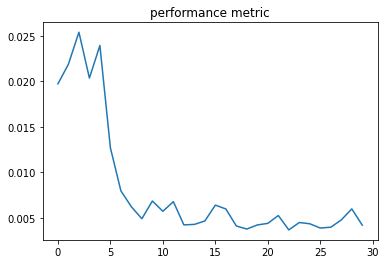

In [17]:
predict, model = LSTM_model(train_x, train_y, test_x, test_y)

This first plot is the LSTM prediction vs the original data on the test set.

The second plot is the in-sample predictions on the training set. 

And the last plot is the performance plot, i.e., the MSE on the test set as a function of the number epochs. From the performance plot, there is not obvious overfitting, which is good.

This LSTM prediction model will be used to generate the prediction in the state of the reinforment learning enviroment.

PART 2: deep reinforcement learning for BTC trading

First, I build an environment class for BTC trading, i.e., DQN agent can do trading in this enviroment just like we can do in the real market. But for simplicity, the agent can only choose to buy, sell BTC for a certain amount (discretized action space). The rewards at this moment is simply the profit made by each action. 

In [19]:
import gym
class trading_Env(gym.Env):
    def __init__(self, Open, Close, High, Low, Volume_BTC, Volume_Currency, Weighted_Price, windows, initial_cash, initial_BTC, forecast_size, model):#Series
        #market data
        self.Open = Open.values.reshape(-1, 1)
        self.Close= Close.values.reshape(-1, 1)
        self.High = High.values.reshape(-1, 1)
        self.Low = Low.values.reshape(-1, 1)
        self.Volume_BTC = Volume_BTC.values.reshape(-1, 1)
        self.Volume_Currency = Volume_Currency.values.reshape(-1, 1)
        self.Weighted_Price = Weighted_Price.values.reshape(-1, 1)
        self.market = np.concatenate([self.Open, self.Close, self.High, self.Low, self.Volume_Currency, self.Weighted_Price ], axis=1)

        self.windows = windows
        # observation matrix
        self.obs_next = self.market[:self.windows, :]
        #balance matrix
        self.cash_balance = initial_cash
        self.BTC_balance = initial_BTC
        self.total_balance = self.cash_balance + self.BTC_balance * self.obs_next[-1, -1]
        self.balance = np.matrix([[self.cash_balance, self.BTC_balance, self.total_balance] for _ in range(self.windows)])
        #history
        self.history_temp = np.concatenate([self.obs_next, self.balance], axis=1)
        self.history = np.concatenate([self.obs_next, self.balance], axis=1)
        #predictions
        self.forecast_size = forecast_size
        self.prediction_model = model
        self.predictions = self.prediciton()
        self.prediction_history = self.predictions
        #env parameters
        self.current_step = 0
        self.action_space = gym.spaces.Discrete(21)
        self.observation_space = gym.spaces.Box(low=0, high=100000, shape=((self.history.shape[0]*self.history.shape[1]) + self.forecast_size, 1))#state shape (-1,1)

    def prediciton(self):
        scaler = STDscaler
        test = self.obs_next[:, -1]
        test = scaler.transform(test.reshape(-1, 1)) 
        test = test.reshape(1, 1, -1)
        pred = []
        for i in range(self.forecast_size):
            pred_temp = self.prediction_model.predict(test, batch_size=1)
            test[0, 0, :-1] = test[0, 0, 1:]
            test[0, 0, -1] = pred_temp
            pred.append(scaler.inverse_transform(pred_temp))
        pred = np.array(pred)
        return pred.reshape(1, -1)

    def take_action(self, action):
        if action <= 9:
            cash = self.balance[-1, 0] * (1 - ((action+1)/10))
            btc = self.balance[-1, 1] + (self.balance[-1, 0] * ((action+1)/10) / self.obs_next[-1, -1])#use weighted price
            total = cash + btc * self.obs_next[-1, -1]
        elif action == 20:
            cash = self.balance[-1, 0]
            btc = self.balance[-1, 1]
            total = self.balance[-1, 2]
        else:
            cash = self.balance[-1, 0] + (((action-9)/10) * self.balance[-1, 1]) * self.obs_next[-1,-1]
            btc = self.balance[-1, 1] * (1 - (action-9)/10)
            total = cash + btc * self.obs_next[-1, -1]

        #update self.balance
        balance_temp = np.array([cash, btc, total])
        self.balance[:-1, :] = self.balance[1:, :]
        self.balance[-1, :] = balance_temp.reshape(1, 3)
        #update self.obs_next
        self.current_step += 1
        if self.current_step + self.windows >= self.market.shape[0]:
            print('running out of market data')
            self.reset()
        self.obs_next = self.market[self.current_step:self.current_step + self.windows, :]
        #update history
        self.history_temp = np.concatenate([self.obs_next, self.balance], axis=1)
        self.history = np.concatenate([self.history, self.history_temp[-1, :].reshape(1, -1)], axis=0)
        #update self.predictions
        self.predictions = self.prediciton()
        self.prediction_history = np.concatenate([self.prediction_history, self.predictions], axis=0)

    def reward(self):
        rewards = (self.balance[-1, 0] + self.balance[-1, 1] * self.obs_next[-1, -1]) - self.balance[-1,  -1]
        return rewards

    def done(self):
        if (self.current_step + self.windows >= self.market.shape[0]):
            print('running out of data')
            return True
        elif (self.balance[-1, -1] < 0.3 * self.total_balance):
            print('bankrupt')
            return True
        else:
            return False

    def transform_to_state(self):
        state = self.history_temp.reshape(1, -1)
        state = np.concatenate([state, self.predictions], axis=1)
        return state 

    def step(self, action):
        self.take_action(action)
        rewards = self.reward()
        state = self.transform_to_state()
        done = self.done()
        return state, rewards, done, {}

    def reset(self):
        self.current_step = 0
        self.obs_next = self.market[:self.windows, :]
        self.balance = np.matrix(
            [[self.cash_balance, self.BTC_balance, self.total_balance] for _ in range(self.windows)])  # ndarray
        self.history_temp = np.concatenate([self.obs_next, self.balance], axis=1)
        self.history = np.concatenate([self.obs_next, self.balance], axis=1)
        self.predictions = self.prediciton()
        self.prediction_history = self.predictions
        state = self.transform_to_state()
        return state

    def close(self):
        if self.viewer is not None:
            self.viewer.close()
            self.viewer = None

    def render(self):
        cash_plt = self.history[:, 6]
        BTC_plt = self.history[:, 7]
        total_plt = self.history[:, 8]
        plt.figure()
        plt.plot(np.linspace(1, len(cash_plt), len(cash_plt)), cash_plt, '--o')
        plt.plot(np.linspace(1, len(cash_plt), len(cash_plt)), total_plt, '-ok')
        plt.legend(['cash in hand', 'total asset'])
        plt.figure()
        plt.plot(np.linspace(1, len(cash_plt), len(cash_plt)), BTC_plt, '--o')
        plt.legend(['# BTC'])
        w = self.history[:, 5]
        pred_plot1 = self.prediction_history[:, 0]
        pred_plot2 = self.prediction_history[:, 1]
        plt.figure()
        plt.plot(np.linspace(1, len(w), len(w)), w, '-o')
        plt.plot(pred_plot1, '-o')
        plt.plot(pred_plot2, '-o')
        plt.legend(['Close', 'pred1', 'pred2'])
        plt.show()

Now, I build the DQN agent class.

In [20]:
import collections
class DQN():
    def __init__(self, env):
        self.env = env
        self.model = self.build_model()
        self.target_model = self.build_model()

        self.epsilon = 0.1#epsilon greedy for selecting action

        self.pool_size = 200
        self.experience_pool = collections.deque(maxlen=self.pool_size)
        self.batch_size = 32#batch size of each sample from the experience pool

        self.gamma = 0.01#rewards decay
        self.alpha = 0.5#target weight update portion


    def build_model(self):
        model = Sequential()
        input_dim = self.env.observation_space.shape[0]
        output_dim = 21
        model.add(Dense(100, input_shape=(input_dim, ), activation='relu'))
        model.add(Dense(25, activation='relu'))
        model.add(Dense(output_dim))
        model.compile(optimizer='Adam', loss='mean_squared_error')
        return model

    def epsilon_greedy_action(self, state):#state has the same form as state in env
        rd = np.random.uniform()
        if rd > self.epsilon:
            act = np.argmax(self.model.predict(state))
        else:
            act = self.env.action_space.sample()
        return act

    #experience pool
    def save_into_pool(self, state, act):
        state_next, rewards, done, info = self.env.step(act)
        #print(state.shape)
        #print(state_next.shape)
        new_sample = [state, act, rewards, state_next, done]
        self.experience_pool.append(new_sample)
        return state_next, rewards, done

    def initial_experience_pool(self):
        i = 0
        while True:
            if i > self.pool_size:
                break
            state = self.env.reset()
            while True:
                i += 1
                act = self.env.action_space.sample()
                state_next, rewards, done = self.save_into_pool(state, act)
                state = state_next
                if done or i > self.pool_size:
                    break

    def sample_from_pool(self):
        training_samples = random.sample(self.experience_pool, self.batch_size)
        return training_samples

    #batch training
    def train_batch(self):
        training_samples = self.sample_from_pool()
        x_train = []
        y_train = []
        for sample in training_samples:
            state, act, rewards, state_next, done = sample
            x_train.append(state)
            target = self.target_model.predict(state)
            #print(target)
            if done:
                target[0][act] = rewards
            else:
                target[0][act] = rewards + self.gamma * np.max(self.target_model.predict(state_next))
            y_train.append(target)
        x_train = np.squeeze(np.array(x_train))#ndarray(32.92)
        y_train = np.squeeze(np.array(y_train))#ndarray(32.21)
        self.model.fit(x_train, y_train, epochs=10, verbose=0)

    def update_target_model(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        #self.target_model.set_weights(weights)#simply update by weights
        for i in range(len(weights)):
            target_weights[i] = (1 - self.alpha) * target_weights[i] + self.alpha * weights[i]
        self.target_model.set_weights(target_weights)

    def model_save(self, name):
        self.model.save(name)

Defining the training function with initial cash of 10000 dollar and 0 initial BTC.

In [44]:
import random
def DQN_train(Open, Close, High, Low, Volume, model, epochs, iterations):
    Volume_BTC = Volume
    Volume_Currency = Volume
    Weighted_price = Close

    start_cash = 10000
    start_BTC = 0
    windows = 10
    forecast_size = 2
    env = trading_Env(Open, Close, High, Low, Volume_BTC, Volume_Currency, Weighted_price, windows, start_cash, start_BTC, forecast_size, model)
    DQN_agent = DQN(env)

    DQN_agent.initial_experience_pool()
    print('initial pool finished')
    for epoch in range(epochs):
        print('epoch: ', epoch)
        state = DQN_agent.env.reset()
        for iteration in range(iterations):
            #print('iteration: ', iteration)
            act = DQN_agent.epsilon_greedy_action(state)
            state_next, rewards, done = DQN_agent.save_into_pool(state, act)
            DQN_agent.train_batch()
            if iterations%10 == 0:
                DQN_agent.update_target_model()
            state = state_next
            if done:
                break
    DQN_agent.env.render()
    return DQN_agent.model

Train with only 1 epochs and 100 iterations in each epoch.

initial pool finished
epoch:  0


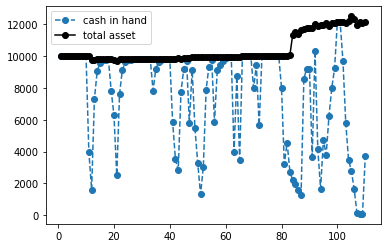

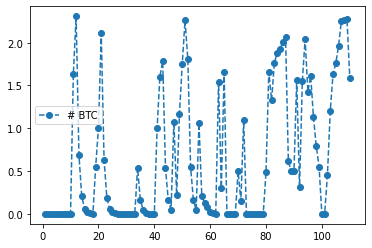

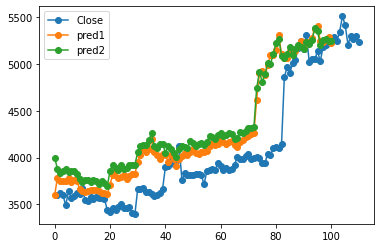

In [45]:
DQN_model = DQN_train(Open, Close, High, Low, Volume, model, 1, 100)

The black curve shows the total asset as the reinforcement learning agent trades, while the blue dashed-dotted curves shows the trading action of the agent (number of BTC increses when cash decrease as an action of buying BTC with cash in hand). This looks like some random trading strategy that doesn't make great profit since this DQN was not fully trained.

Then, let's see what happend if I train it much deeper (15 epochs with 700 iterations for each epoch).

initial pool finished
epoch:  0
running out of market data
epoch:  1
running out of market data
epoch:  2
running out of market data
epoch:  3
running out of market data
epoch:  4
running out of market data
epoch:  5
running out of market data
epoch:  6
running out of market data
epoch:  7
running out of market data
epoch:  8
running out of market data
epoch:  9
running out of market data
epoch:  10
running out of market data
epoch:  11
running out of market data
epoch:  12
running out of market data
epoch:  13
running out of market data
epoch:  14
running out of market data


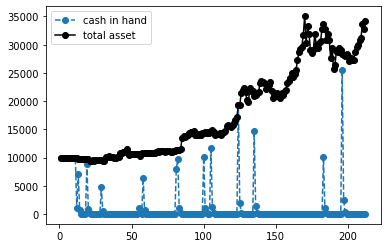

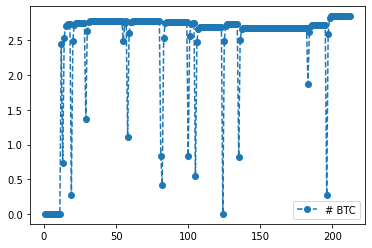

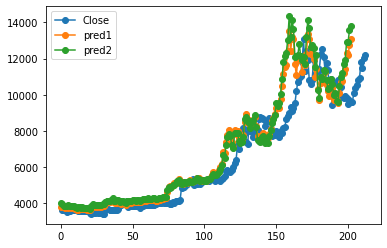

In [51]:
DQN_model = DQN_train(Open, Close, High, Low, Volume, model, 15, 700)

After a deep training, this DQN agent seems to have a preference of buying BTC and hold them. 

This strategy of 'buy and hold' is actually a very good one in BTC market from today's point of view. 


Let's validate this model on a separated untouched data set, i.e., the historcial price data from Jan 2019 to June 2020. Here is what this data looks like. 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


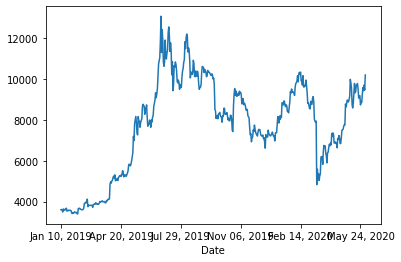

In [52]:
path = 'my/My Drive/BTC_DQN/data/Bitcoin_2019_1_10_to_2020_6_1.csv'
df = pd.read_csv(path)
Date = df['Date'].iloc[::-1]
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df['Open'] = df['Open'].str.replace(',', '').astype(float)
df['High'] = df['High'].str.replace(',', '').astype(float)
df['Low'] = df['Low'].str.replace(',', '').astype(float)
for i in range(len(df['Vol.'])):
    if 'K' in df['Vol.'].iloc[i]:
        df['Vol.'].iloc[i] = float(df['Vol.'].iloc[i][:-1]) * 1000
    elif 'M' in df['Vol.'].iloc[i]:
        df['Vol.'].iloc[i] = float(df['Vol.'].iloc[i][:-1]) * 1000000
    else:
        df['Vol.'].iloc[i] = float(df['Vol.'].iloc[i])
Close = pd.Series(df['Price'].values[::-1], index=Date)
Open = pd.Series(df['Open'].values[::-1], index=Date)
High = pd.Series(df['High'].values[::-1], index=Date)
Low = pd.Series(df['Low'].values[::-1], index=Date)
Volume = pd.Series(df['Vol.'].values[::-1], index=Date)
Close.plot()

Define a validataion function.

In [64]:
def DQN_validation(Close, Open, High, Low, Volume, model, DQN_model):
    cash =10000
    BTC = 0
    windows = 10
    forecast_size = 2

    env = trading_Env(Open, Close, High, Low, Volume, Volume, Close, windows, cash, BTC, forecast_size, model)
    DQN_validate = DQN(env)
    DQN_validation.model = DQN_model
    state = DQN_validate.env.reset()
    DQN_validate.epsilon = 0
    for i in range(len(Close)-windows-1):
        act = DQN_validate.epsilon_greedy_action(state)
        state_next, rewards, done, info = DQN_validate.env.step(act)
        state = state_next
    DQN_validate.env.render()


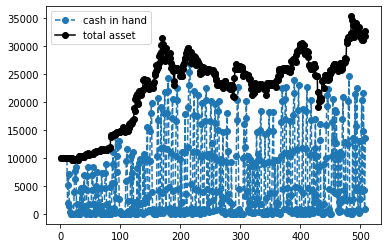

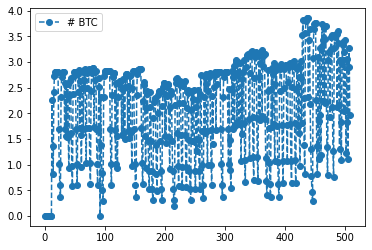

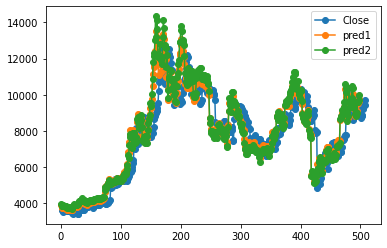

In [65]:
DQN_validation(Close, Open, High, Low, Volume, model, DQN_model)

From this validation, it seems that this stratgy is pretty good. At the end of the period, my total asset is increased by 3.5 time while the price is only increased by 2.5 times. This shows that my strategy out-perform the market !!(even thought it still tends to holding BTC.)  

In future works, I will try to see if there is any better strategy can be found by focusing on the fluctuation of the historical data. In this case, the dependency of strategy on the trend can be eliminated, which will have a more general application.  